This is not a priority, just good to do if have time because there are some redundancy is Naomi's code

# TRIPPING OPTIMIZATION (WIP)
1. Remove redundancy
2. Adjust the generated energy to be consistent

In [ ]:
# --------------------------------- Reductions immediately before zero
# Falling dramatically before zeros
data['start_deriv_flag'] = 0
# Just get the first instance of ramp down
# e.g. Times where zero flag (t+1) = 1, zero flag (t) <>1 and cf_first_deriv < limit
data.loc[(data['zero_flag'].shift(-1) == 1) & (data['zero_flag'] == 0) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
# Dealing with 'soft' disconnect
# Next interval is zero flagged, current value is greater than 'zero' limit
data.loc[(data['zero_flag'].shift(-1) == 1) & (data['cf'] > CF_ZERO_APPROX),'start_deriv_flag'] = 1

# Get the next instance of ramp down (well, previous) - repeat four times. Effectively means you can capture periods in which power falls over 5 time intervals (including initial one captured above)
data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1

# --------------------------------- Increases immediately after zero
# Increasing dramatically after zeros
data['end_deriv_flag'] = 0
# Just get the first instance of ramp up
# e.g. Times where zero flag (t) = 1, zero flag (t+1) <>1 and cf_first_deriv > limit
data.loc[(data['zero_flag'].shift(-1) == 0) & (data['zero_flag'] == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
# Dealing with 'soft' restarts.
# Previous value was zero flagged, current value is greater than the 'zero' limit
data.loc[(data['zero_flag'].shift(+1) == 1) & (data['cf'] > CF_ZERO_APPROX),'end_deriv_flag'] = 1

# Get next instances (x8 as slower ramp up potentially)
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1

# --------------------------------- Get 'ramp' start and end points
# Get start points
data['start_pts'] = 0
# Case where 'start_derive_flag' is zero in previous interval (t-1), and one in current interval (t)
data.loc[(data['start_deriv_flag'].shift(+1) == 0) & (data['start_deriv_flag'] == 1),'start_pts'] = 1

# Get end points
data['end_pts'] = 0
# Case where 'end_deriv_flag' is 1 in previous interval (t-1), and 0 in current interval (t)
data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['end_deriv_flag'] == 0),'end_pts'] = 1

In [33]:
#file_path = r"/Users/samhan/Downloads/data" #this is for running in Samhan's laptop
file_path = r"C:\Users\samha\Documents\CANVAS\data" #for running in TETB CEEM09 computer
site_details, unique_cids= input_general_files(file_path)
summary_all_samples = pd.DataFrame()
sample_number = 1
sample_filename = '/data_sample_{}.csv'.format(sample_number)
ghi_filename = '/ghi_sample_{}.csv'.format(sample_number)

data = pd.read_csv(file_path + sample_filename)
size_is_ok = check_data_size(data)
if not size_is_ok:
    print('Cannot analyze sample {} due to incomplete data.'.format(i))
else:
    ghi = pd.read_csv(file_path + ghi_filename, index_col = 0)
    ghi.index = pd.to_datetime(ghi.index)
    pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data['Timestamp'] = pd.to_datetime(data['Timestamp'].str.slice(0, 19, 1))
    data.set_index('Timestamp', inplace=True)

    c_id = data['c_id'][0]
    date = str(data.index[0])[:10]

    data_site, ac_cap, dc_cap, EFF_SYSTEM, inverter = site_organize(c_id, site_details, data, unique_cids)
    data_site = resample_in_minute(data_site)
    
    ZERO_POWER_LIMIT = 0.01 * ac_cap
    DERIV_LIMIT = 0.05 * ac_cap
    #DERIV_LIMIT = 0 #experimentation

    #check the expected power using contrained polyfit
    data_site, a, is_good_polyfit_quality = check_polyfit_constrained(data_site)

    is_clear_sky_day = check_clear_sky_day(date)
    #energy_generated = check_energy_generated(data_site, date)

In [34]:
data_site['power_deriv'] = data_site['power'].shift(-1) - data_site['power']
#data_site['power_deriv'] = data_site['power'] - data_site['power'].shift(-1)
#before & after

data_site.loc[data_site['power'] < ZERO_POWER_LIMIT, 'is_zero'] = True
#Naomi change the power < ZERO POWER LIMIT to zero.. I don't think we should do that.

In [35]:
trip_after = (data_site['is_zero'].shift(-1) == True) & (data_site['is_zero'] != True)
trip_before = (data_site['is_zero'].shift(1) == True) & (data_site['is_zero'] != True)
#first_deriv_neg = (data_site['power_deriv'] < - DERIV_LIMIT)
#first_deriv_pos =  (data_site['power_deriv'].shift(1) > DERIV_LIMIT)
data_site.loc[trip_after, 'ramp_down'] = True
data_site.loc[trip_before, 'ramp_up'] = True

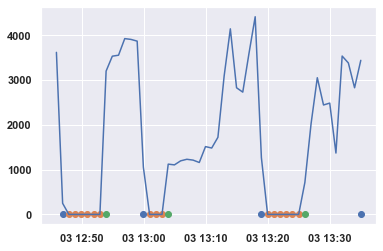

In [36]:
low = 350
high = 400

plt.plot(data_site.index[low:high], data_site['power'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['ramp_down'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['is_zero'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['ramp_up'].iloc[low:high])
#plt.plot(data_site['power_expected_linear'].iloc[350:370])

In [37]:
last_count = 0
# include ramping down before zero power as tripping period
for i in range(2000):
    ramp_down_after = (data_site['ramp_down'].shift(-1) == True)
    first_deriv_neg = (data_site['power_deriv'] < - DERIV_LIMIT)
    data_site.loc[ramp_down_after & first_deriv_neg, 'ramp_down'] = True
    ramp_count = data_site['ramp_down'].sum()
    print(ramp_count)
    if ramp_count == last_count:
        break
    else:
        last_count = ramp_count

36
36


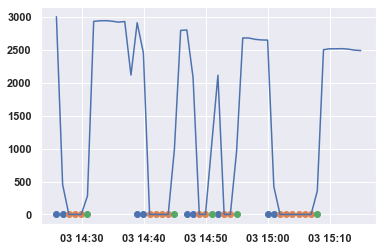

In [38]:
low = 450
high = 500

plt.plot(data_site.index[low:high], data_site['power'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['ramp_down'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['is_zero'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['ramp_up'].iloc[low:high])
#plt.plot(data_site['power_expected_linear'].iloc[350:370])

In [39]:
last_count = 0
for i in range(2000):
    #include ramping up after zero power as tripping period
    ramp_up_before = (data_site['ramp_up'].shift(1) == True)
    first_deriv_pos =  (data_site['power_deriv'].shift(1) > DERIV_LIMIT)
    data_site.loc[ramp_up_before & first_deriv_pos, 'ramp_up'] = True
    ramp_count = data_site['ramp_up'].sum()
    print(ramp_count)
    if ramp_count == last_count:
        break
    else:
        last_count = ramp_count

39
41
41


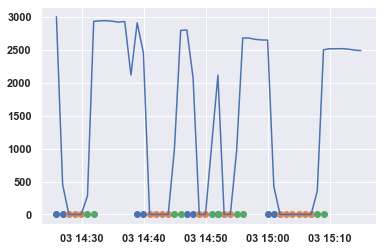

In [47]:
low = 450
high = 500

plt.plot(data_site.index[low:high], data_site['power'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['ramp_down'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['is_zero'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['ramp_up'].iloc[low:high])
#plt.plot(data_site['power_expected_linear'].iloc[350:370])

In [50]:
data_site['power'].shift(-1)

2019-09-03 06:51:55    13.350000
2019-09-03 06:52:55    13.750000
2019-09-03 06:53:55    15.716667
2019-09-03 06:54:55    18.483333
2019-09-03 06:55:55    20.200000
                         ...    
2019-09-03 17:44:55    17.483333
2019-09-03 17:45:55    15.583333
2019-09-03 17:46:55    13.983333
2019-09-03 17:47:55    12.500000
2019-09-03 17:48:55          NaN
Name: power, Length: 653, dtype: float64

In [52]:
data_site.loc[(data_site['ramp_down'] == 1) & (data_site['ramp_down'].shift(1) != 1), 'start_tripping'] = 1
data_site.loc[(data_site['ramp_up'] == 1) & (data_site['ramp_up'].shift(-1) != 1), 'end_tripping'] = 1

In [56]:
count_start_tripping = data_site['start_tripping'].sum()
count_end_tripping = data_site['end_tripping'].sum()

if count_start_tripping != count_end_tripping:
    print('Start and end tripping number are not the same')
    #return()
else:
    count_tripping_event = count_start_tripping

In [57]:
data_site.loc[data_site['start_tripping'] == True,'trip_num'] = data_site.loc[data_site['start_tripping'] == True, 'start_tripping'].astype(int).cumsum()
data_site.loc[data_site['end_tripping'] == True,'trip_num'] = data_site.loc[data_site['end_tripping'] == True, 'end_tripping'].astype(int).cumsum()

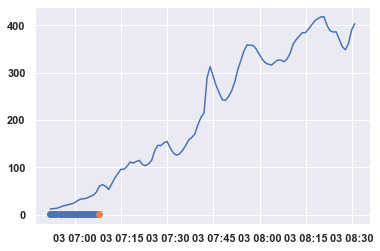

In [82]:
low = 0
high = 100

plt.plot(data_site.index[low:high], data_site['power'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['is_zero'].iloc[low:high])
#plt.scatter(data_site.index[low:high], data_site['start_tripping'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['end_tripping'].iloc[low:high])
#plt.plot(data_site['power_expected_linear'].iloc[350:370])

In [66]:
last_count_trip_point = data_site['trip_num'].count()
for i in range(2000):
    filt_1 = data_site['trip_num'].shift(1) > 0
    filt_2 = data_site['end_tripping'].shift(-1) != True
    
    data_site.loc[filt_1 & filt_2, 'trip_num'] = data_site['trip_num'].shift(1)
    count_trip_point = data_site['trip_num'].count()
    
    if count_trip_point == last_count_trip_point:
        break
    else:
        last_count_trip_point = count_trip_point 

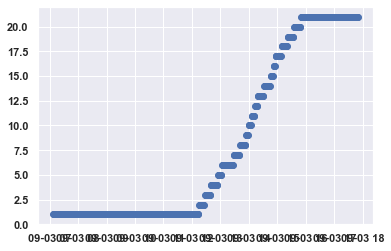

In [67]:
plt.scatter(data_site.index, data_site['trip_num'])

In [68]:
data_site['trip_num'].value_counts()

1.0     303
21.0    119
6.0      23
20.0     14
4.0      14
7.0      13
14.0     13
17.0     12
19.0     12
13.0     12
18.0     12
3.0      11
8.0      11
2.0      11
5.0       8
11.0      6
15.0      5
10.0      5
9.0       5
12.0      5
16.0      3
Name: trip_num, dtype: int64

In [70]:
count_tripping_event

21.0

In [71]:
for i in range(1, int(count_tripping_event + 1)):
    filter_event = data_site['trip_num'] == i
    data = data_site[filter_event]
    x1 = data['x_fit'][0]
    x2 = data['x_fit'][-1]
    y1 = data['power'][0]
    y2 = data['power'][-1]
    
    m = (y2-y1)/(x2-x1)
    data_site.loc[filter_event, 'power_expected_linear'] = y1 + m*(data_site.loc[filter_event, 'x_fit'] - x1)

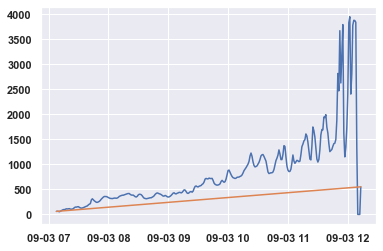

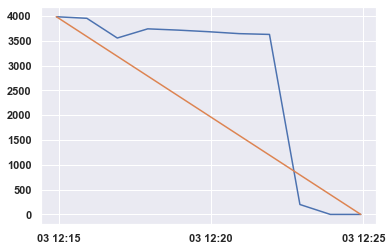

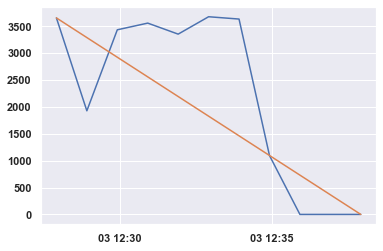

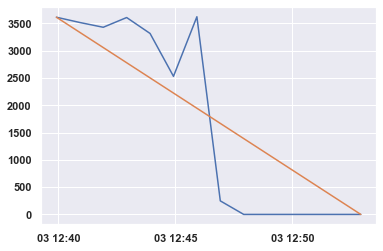

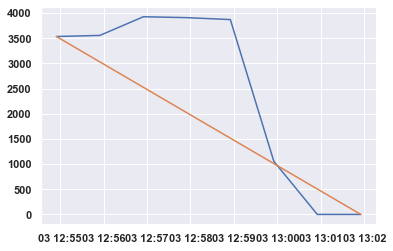

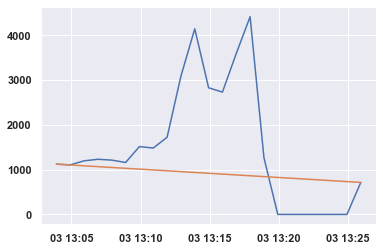

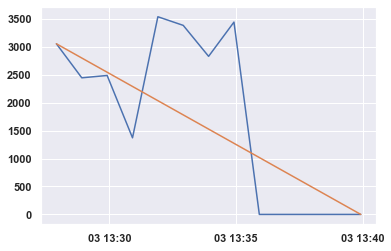

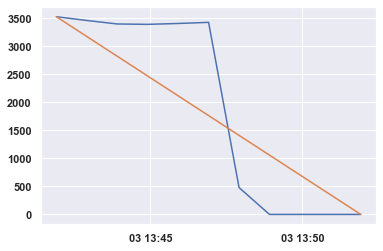

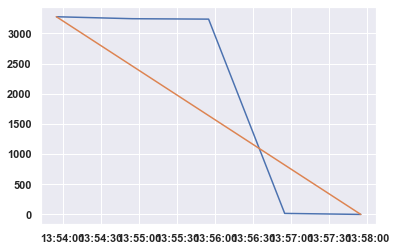

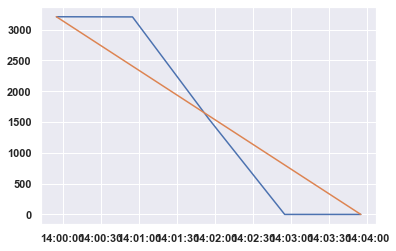

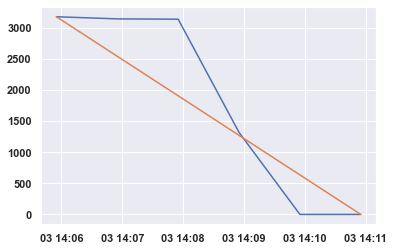

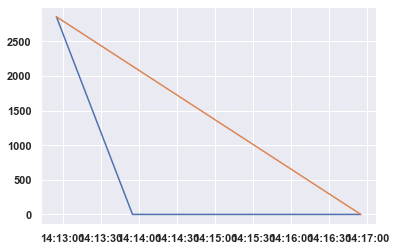

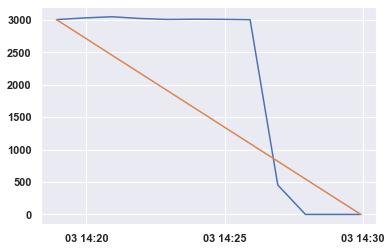

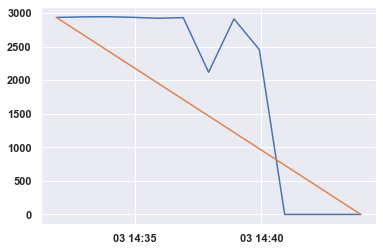

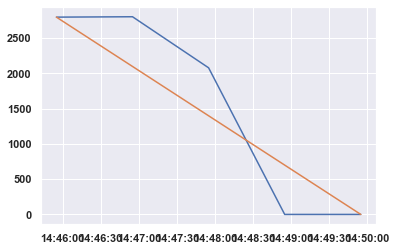

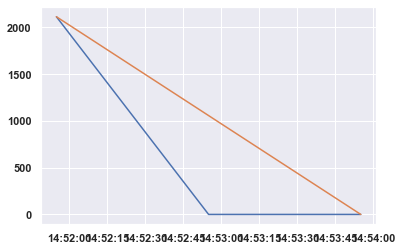

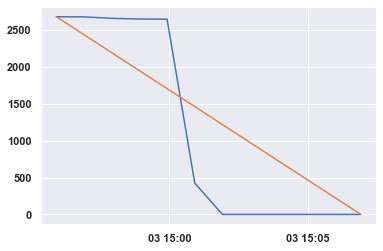

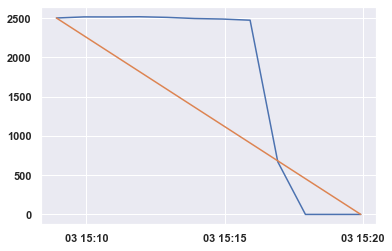

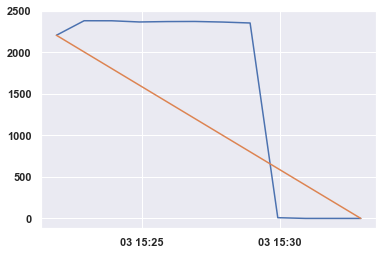

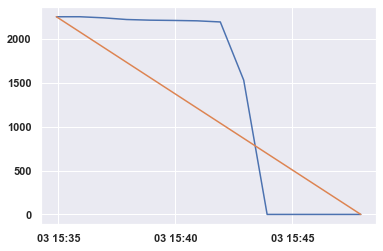

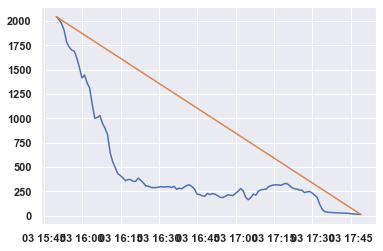

In [73]:
for i in range(1, int(count_tripping_event + 1)):
    plt.plot(data_site.loc[data_site['trip_num'] == i].index, data_site.loc[data_site['trip_num'] == i, 'power'])
    plt.plot(data_site.loc[data_site['trip_num'] == i].index, data_site.loc[data_site['trip_num'] == i, 'power_expected_linear'])
    
    plt.show()

In [1066]:
not_tripping = data_site['is_tripping'] != True
lower_expected = data_site['power_expected_linear'] < data_site['power']
data_site.loc[(not_tripping) | (lower_expected), 'power_expected_linear'] = data_site['power']

In [1070]:
count_tripping_event

7

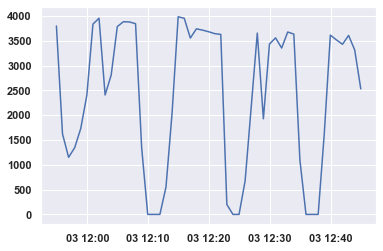

In [1193]:
low = 300
high = 350

plt.plot(data_site.index[low:high], data_site['power'].iloc[low:high])
#plt.plot(data_site.index[low:high], data_site['power_expected_linear'].iloc[low:high])
plt.scatter(data_site.index[low:high], data_site['ramp_up'].iloc[low:high])
#plt.plot(data_site['power_expected_linear'].iloc[350:370])